In [2]:
import codecs
import math
import random
import string
import time
import numpy as np
import torch
from sklearn.metrics import accuracy_score

'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


import unicodedata

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/cities/train/*.txt'))


for filename in findFiles('data/cities/train/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/cities/train/in.txt', 'data/cities/train/pk.txt', 'data/cities/train/fr.txt', 'data/cities/train/af.txt', 'data/cities/train/cn.txt', 'data/cities/train/za.txt', 'data/cities/train/fi.txt', 'data/cities/train/ir.txt', 'data/cities/train/de.txt']


Explore the train dataset by computing basic descriptive statistics: number of categories, tokens per category, number of characters, distinct characters, average number of characters per token.



we got a dictionary - the keys are the languages and the value is a list of words.
let's look a one list for language 'de':

In [35]:
category_lines['de'][:10]

['rudenweiler',
 'comunidad pallina grande',
 'joao lopes de cima',
 'los aymanes de san miguel',
 'am badeche',
 'hesedorf',
 'lohnerheide',
 'istermyrliden',
 'kleinlellenfeld',
 'hadeth baalbek']

Let examine our data:
how many categories do we have?

In [5]:
n_categories

9

every category is a language, what language do we have in this dataset?

In [6]:
all_categories

['in', 'pk', 'fr', 'af', 'cn', 'za', 'fi', 'ir', 'de']

how many token do we have in each category?

In [7]:
{lang:len(category_lines[lang]) for lang in all_categories}

{'in': 3000,
 'pk': 3000,
 'fr': 3000,
 'af': 3000,
 'cn': 3000,
 'za': 3000,
 'fi': 3000,
 'ir': 3000,
 'de': 3000}

In [8]:
category_lines['ir'][3]

'zvirblaukys'

so we have 3000 tokens for each language.

lets look at characters

In [9]:
char={}
for lang in all_categories:
    char[lang]=sum([len(category_lines[lang][word]) for word in range(len(category_lines[lang]))])

In [10]:
char

{'in': 33991,
 'pk': 34561,
 'fr': 33448,
 'af': 32537,
 'cn': 28946,
 'za': 33110,
 'fi': 31037,
 'ir': 33172,
 'de': 37377}

In [11]:
print(f'max: {max(char.values())} min: {min(char.values())}')

max: 37377 min: 28946


in all languages we have between 28k to 38k characters


lets see the average of letter in each token:

In [12]:
import statistics
avg= {lang: statistics.mean([len(category_lines[lang][word])  for word in range(3000)]) for lang in all_categories}

In [13]:
avg

{'in': 11.330333333333334,
 'pk': 11.520333333333333,
 'fr': 11.149333333333333,
 'af': 10.845666666666666,
 'cn': 9.648666666666667,
 'za': 11.036666666666667,
 'fi': 10.345666666666666,
 'ir': 11.057333333333334,
 'de': 12.459}

In [14]:
print(f'mean of average char per token in all language is {statistics.mean(avg.values())}')

mean of average char per token in all language is 11.043666666666667


The average of characters per token is similar in almosgt all languages - around 11

In [15]:
diff_char= {lang: set([char for word in range(3000) for char in category_lines[lang][word]]) for lang in all_categories }

In [16]:
diff_char['af']

{' ',
 "'",
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [17]:
{lang:len(diff_char[lang]) for lang in diff_char.keys()}

{'in': 29,
 'pk': 29,
 'fr': 29,
 'af': 28,
 'cn': 27,
 'za': 29,
 'fi': 29,
 'ir': 29,
 'de': 29}

In [18]:
print(f'total number of possible letters: {n_letters}')
print(f'all letters :\n {all_letters}')

total number of possible letters: 57
all letters :
 abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


Explain why the unicodeToAscii is a good idea for this task.

# MODEL

3.3
Adopt the code of the PyTorch tutorial to run on this new dataset. Report on performance in a similar manner. Explain the main confusion cases observed in the confusion matrix.


In [19]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


#examples

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [20]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [21]:
#example:
input_ = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output_A, next_hidden = rnn(input_, hidden)
print(f'output: {output_A}\n')
print(f'next hidden: {next_hidden}')

output: tensor([[-2.1779, -2.1690, -2.2270, -2.2555, -2.1105, -2.2206, -2.1577, -2.1993,
         -2.2675]], grad_fn=<LogSoftmaxBackward>)

next hidden: tensor([[-0.0479, -0.1053,  0.1064, -0.0308,  0.0984, -0.1019, -0.1125,  0.0310,
         -0.0128, -0.0682,  0.0289,  0.0008,  0.0316, -0.0944,  0.0458,  0.0968,
          0.0205, -0.0556,  0.0112,  0.0524,  0.0173,  0.0538,  0.0836,  0.0012,
          0.0129,  0.0523, -0.1120,  0.0396,  0.0375, -0.0587,  0.0612, -0.0145,
         -0.0284,  0.0878, -0.0641, -0.1184,  0.0964, -0.0377, -0.0300,  0.0012,
          0.0287, -0.0049, -0.0211, -0.0785, -0.0333, -0.0295, -0.0078,  0.0542,
         -0.0555, -0.0547, -0.1107,  0.0446,  0.0977,  0.0558, -0.1037, -0.0510,
          0.0782,  0.0104, -0.0217,  0.0591,  0.0591, -0.1299,  0.0296, -0.0231,
         -0.0252, -0.1053, -0.0231,  0.0545,  0.0427, -0.0774,  0.0394,  0.0197,
         -0.0645,  0.0387,  0.1371,  0.0538, -0.0306, -0.0349, -0.0559,  0.0123,
         -0.0015,  0.0273,  0.0517, -

In [22]:
#example
input_ = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_[0], hidden)
print(f'output: {output}')

output: tensor([[-2.1779, -2.1690, -2.2270, -2.2555, -2.1105, -2.2206, -2.1577, -2.1993,
         -2.2675]], grad_fn=<LogSoftmaxBackward>)


In [23]:
output_A==output

tensor([[True, True, True, True, True, True, True, True, True]])

we got the same tensor for the letter A

In [24]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))



('cn', 4)


In [25]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/line =', line)

category = fr /line = battrans
category = fi /line = timola
category = af /line = bamahgah
category = ir /line = kironjengwale
category = za /line = zaratamo
category = ir /line = musaabade olya
category = in /line = colline nyarurama
category = za /line = m'zamburu
category = ir /line = safid zangul
category = fr /line = le petit fay



the loss function we use is NLLLoss

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss


# training

In [26]:
#training
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn


#input=  line_tensor 
#target output= category_tensor
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


In [27]:
input_ = lineToTensor('Albert')
category_tensor = torch.tensor([all_categories.index('ir')], dtype=torch.long)

output, loss= train(category_tensor, input_)
print(loss)

2.11519193649292


In [28]:
category, line, category_tensor, line_tensor = randomTrainingExample()
print(category, line)
train(category_tensor, line_tensor )

in gatine toy


(tensor([[-2.2551, -2.1262, -2.1680, -2.2041, -2.1084, -2.1823, -2.2827, -2.2073,
          -2.2551]], grad_fn=<LogSoftmaxBackward>),
 2.2550599575042725)

In [29]:
category, line, category_tensor, line_tensor = randomTrainingExample()
print(category, line)
output, loss=train(category_tensor, line_tensor )
print(loss)

fr trefin
2.1327240467071533


In [30]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 1.9992 kozachek / za ✓
10000 10% (0m 20s) 1.9763 qowme baqi / pk ✗ (af)
15000 15% (0m 30s) nan villaseco de los reyes / in ✗ (de)
20000 20% (0m 41s) nan yuelaiji / in ✗ (cn)
25000 25% (0m 50s) nan kach kakozai / in ✗ (af)
30000 30% (1m 0s) nan bakurzay kalay / in ✗ (af)
35000 35% (1m 12s) nan lalliani / in ✗ (pk)
40000 40% (1m 22s) nan dongyuan xiang / in ✗ (cn)
45000 45% (1m 32s) nan spireh / in ✗ (af)
50000 50% (1m 41s) nan zhuze / in ✗ (cn)
55000 55% (1m 50s) nan kantele / in ✗ (fi)
60000 60% (1m 59s) nan kafin kiro / in ✗ (fi)
65000 65% (2m 8s) nan shuitongpo / in ✗ (cn)
70000 70% (2m 17s) nan zablece / in ✗ (za)
75000 75% (2m 26s) nan dalinggang / in ✓
80000 80% (2m 36s) nan mahe firuzan / in ✗ (fi)
85000 85% (2m 45s) nan masewu / in ✗ (za)
90000 90% (2m 55s) nan filimoni matambo / in ✗ (fi)
95000 95% (3m 5s) nan serreeyraud / in ✗ (fr)
100000 100% (3m 16s) nan howar / in ✗ (pk)


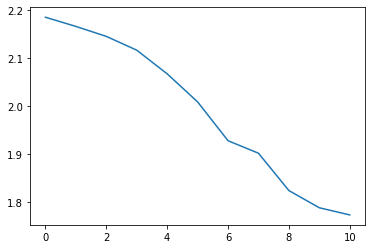

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# evaluating

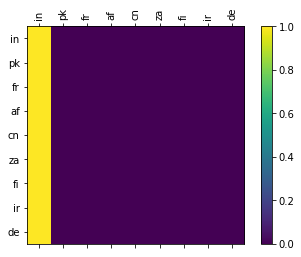

In [32]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [33]:
confusion

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.]])

something is going wrong!


need to add explanation on with language it work

# predict

In [34]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


predict('Dovesky')
predict('Jackson')
predict('Satoshi')




> Dovesky
(nan) in
(nan) pk
(nan) fr

> Jackson
(nan) in
(nan) pk
(nan) fr

> Satoshi
(nan) in
(nan) pk
(nan) fr
